   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 843.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

<ipython-input-1-675964e6065c>:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = price_df.join(sentiment, how='inner').fillna(method='ffill')
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 01/30, Train MSE: 0.118037
Epoch 02/30, Train MSE: 0.064163
Epoch 03/30, Train MSE: 0.037695
Epoch 04/30, Train MSE: 0.035710
Epoch 05/30, Train MSE: 0.039397
Epoch 06/30, Train MSE: 0.056624
Epoch 07/30, Train MSE: 0.018948
Epoch 08/30, Train MSE: 0.017892
Epoch 09/30, Train MSE: 0.016165
Epoch 10/30, Train MSE: 0.018466
Epoch 11/30, Train MSE: 0.012241
Epoch 12/30, Train MSE: 0.011993
Epoch 13/30, Train MSE: 0.025685
Epoch 14/30, Train MSE: 0.013804
Epoch 15/30, Train MSE: 0.015555
Epoch 16/30, Train MSE: 0.009897
Epoch 17/30, Train MSE: 0.016729
Epoch 18/30, Train MSE: 0.012120
Epoch 19/30, Train MSE: 0.011406
Epoch 20/30, Train MSE: 0.009749
Epoch 21/30, Train MSE: 0.009913
Epoch 22/30, Train MSE: 0.009971
Epoch 23/30, Train MSE: 0.009114
Epoch 24/30, Train MSE: 0.009671
Epoch 25/30, Train MSE: 0.015882
Epoch 26/30, Train MSE: 0.010939
Epoch 27/30, Train MSE: 0.010212
Epoch 28/30, Train MSE: 0.009979
Epoch 29/30, Train MSE: 0.009634
Epoch 30/30, Train MSE: 0.008207

Test MSE 

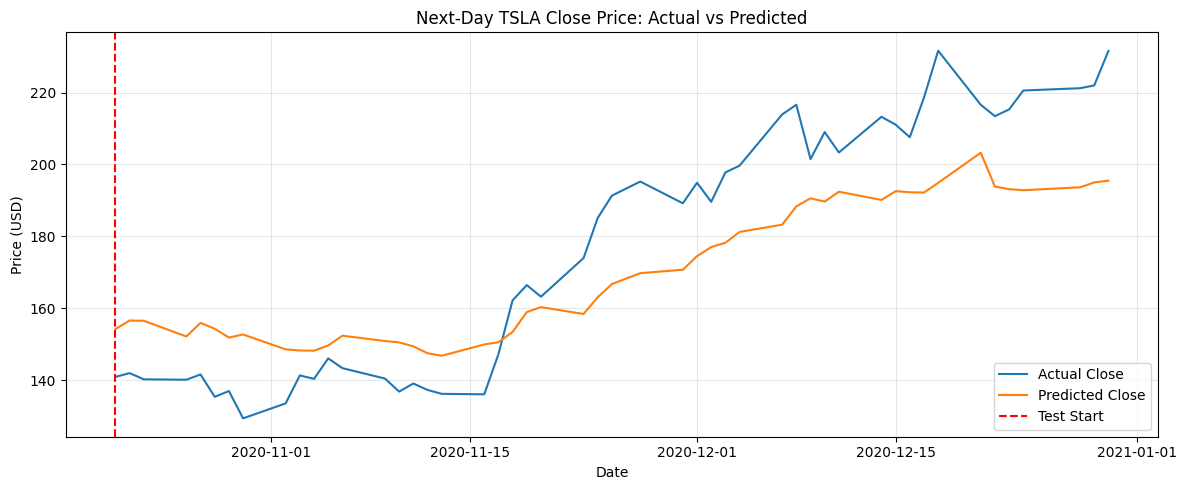

In [1]:
# Install required packages (run once in Colab)
!pip install finance-datareader torch torchvision scikit-learn matplotlib pandas

# 1. Imports and device setup
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Load daily sentiment scores

sent_df = pd.read_csv('daily_sentiment_scores.csv', index_col=0, parse_dates=True)
if 'sentiment_final' in sent_df.columns:
    sentiment = sent_df['sentiment_final']
else:
    sentiment = sent_df.iloc[:, 0]
sentiment.name = 'sentiment_final'

# 3. Load TSLA OHLCV data
start = datetime.datetime(2020, 1, 1)
end   = datetime.datetime(2020, 12, 31)
price_df = fdr.DataReader('TSLA', start, end)[['Open','High','Low','Close','Volume']]
price_df.index = pd.to_datetime(price_df.index)

# 4. Merge price and sentiment on date
df = price_df.join(sentiment, how='inner').fillna(method='ffill')
dates = df.index

# 5. Scale features to [0,1]
feature_cols = ['Open','High','Low','Close','Volume','sentiment_final']
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[feature_cols].values)
close_idx = feature_cols.index('Close')

# 6. Create sliding-window sequences
look_back = 10
X, y = [], []
for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:i+look_back])
    y.append(data_scaled[i+look_back, close_idx])
X = np.stack(X)            # shape: (N, look_back, n_features)
y = np.array(y)[:, None]   # shape: (N, 1)

# 7. Train/test split (80/20)
split = int(len(X) * 0.8)
trainX, testX = X[:split], X[split:]
trainY, testY = y[:split], y[split:]
test_dates = dates[look_back + split:]

# 8. PyTorch Dataset & DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

batch_size = 32
train_dl = DataLoader(TimeSeriesDataset(trainX, trainY), batch_size=batch_size, shuffle=True)
test_dl  = DataLoader(TimeSeriesDataset(testX,  testY), batch_size=batch_size)

# 9. Positional Encoding module
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0).to(device)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# 10. Transformer-based forecaster
class TransformerForecaster(nn.Module):
    def __init__(self, n_features, d_model=64, nhead=4, num_layers=2, dim_ff=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc     = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_ff, dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.regressor   = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: [batch, time, features]
        x = self.input_proj(x)          # → [batch, time, d_model]
        x = self.pos_enc(x)             # add positional encoding
        x = x.permute(1, 0, 2)          # → [time, batch, d_model]
        x = self.transformer(x)         # → [time, batch, d_model]
        out = x[-1, :, :]               # last time step → [batch, d_model]
        return self.regressor(out)      # → [batch, 1]

# 11. Instantiate model, loss, optimizer
model = TransformerForecaster(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 12. Training loop
epochs = 30
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dl)
    print(f"Epoch {epoch:02d}/{epochs}, Train MSE: {avg_loss:.6f}")

# 13. Evaluation on test set
model.eval()
preds, actuals = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        p = model(xb).cpu().numpy()
        preds.append(p)
        actuals.append(yb.numpy())
preds = np.vstack(preds).flatten()
actuals = np.vstack(actuals).flatten()

# 14. Invert scaling for Close price
cmin, cmax = scaler.data_min_[close_idx], scaler.data_max_[close_idx]
pred_prices = preds * (cmax - cmin) + cmin
act_prices  = actuals * (cmax - cmin) + cmin

# 15. Compute test-set MSE
mse_test = mean_squared_error(act_prices, pred_prices)
print(f"\nTest MSE (price units): {mse_test:.4f}")

# 16. Plot actual vs. predicted next-day Close
plt.figure(figsize=(12,5))
plt.plot(test_dates, act_prices, label='Actual Close', color='tab:blue')
plt.plot(test_dates, pred_prices, label='Predicted Close', color='tab:orange')
plt.axvline(test_dates[0], color='red', linestyle='--', label='Test Start')
plt.title('Next-Day TSLA Close Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
